# Cal-CRAI Index: Equal-Weighting Climate Risk

**Order of operations**:
1) Metric handling \
   a) Retrieve & clean data \
   b) Merge data domains together \
   c) Calculate domain medians and adjusted scores \
   d) Pull climate domain and clean & merge

2) Calculate index

3) Visualize index results

4) Bin values into 5 sections based on equal percentiles
   - Visualize
   
5) Export data as a GeoDataBase and upload to AWS
   - Add metadata to GeoDataBase

In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_environment_domain_score.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_score.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_systems_domain_score.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_score.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_hazard_scores.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]
climate_domain_cleaned = climate_domain.iloc[:, :2]

### 1b) Merge data domains together

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Display the dataframe
merged_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score
0,06001400100,0.416058,0.605062,0.589375,0.833488
1,06001400200,0.416058,0.553534,0.514427,0.841855
2,06001400300,0.416058,0.557473,0.450082,0.793298
3,06001400400,0.416058,0.549355,0.474044,0.770451
4,06001400500,0.416058,0.552923,0.463199,0.744977
...,...,...,...,...,...
9124,06115040902,0.459518,0.468943,0.609509,0.783342
9125,06115041001,0.408984,0.416459,0.599682,0.742681
9126,06115041002,0.494739,0.432561,0.616996,0.766956
9127,06115041101,0.456275,0.391202,0.668231,0.736324


### 1c) Calculate data domain median and adjusted columns

In [7]:
all_domains = merged_domains.copy()
all_domains['built_environment_median'] = merged_domains['built_environment_domain_score'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_score'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_score'].median()

all_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median
0,06001400100,0.416058,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805
1,06001400200,0.416058,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805
2,06001400300,0.416058,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805
3,06001400400,0.416058,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805
4,06001400500,0.416058,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805
...,...,...,...,...,...,...,...,...
9124,06115040902,0.459518,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805
9125,06115041001,0.408984,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805
9126,06115041002,0.494739,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805
9127,06115041101,0.456275,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_score'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built_environment']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted
0,06001400100,0.416058,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232
1,06001400200,0.416058,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434
2,06001400300,0.416058,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304
3,06001400400,0.416058,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939
4,06001400500,0.416058,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.459518,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099
9125,06115041001,0.408984,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789
9126,06115041002,0.494739,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726
9127,06115041101,0.456275,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102


## 1d) Pull climate domain and clean & merge

In [9]:
climate_domain_cleaned

,GEOID,hazard_score
0,6001400100,0.753671
1,6001400200,0.704640
2,6001400300,0.764024
3,6001400400,0.702309
4,6001400500,0.781995
...,...,...
9124,6115040902,0.409434
9125,6115041001,0.382023
9126,6115041002,0.396227
9127,6115041101,0.361174


In [10]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,hazard_score
0,06001400100,0.753671
1,06001400200,0.704640
2,06001400300,0.764024
3,06001400400,0.702309
4,06001400500,0.781995
...,...,...
9124,06115040902,0.409434
9125,06115041001,0.382023
9126,06115041002,0.396227
9127,06115041101,0.361174


In [11]:
all_domains['hazard_score'] = climate_domain[['hazard_score']]
all_domains

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score
0,06001400100,0.416058,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232,0.753671
1,06001400200,0.416058,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434,0.704640
2,06001400300,0.416058,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304,0.764024
3,06001400400,0.416058,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939,0.702309
4,06001400500,0.416058,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386,0.781995
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.459518,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099,0.409434
9125,06115041001,0.408984,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789,0.382023
9126,06115041002,0.494739,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726,0.396227
9127,06115041101,0.456275,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102,0.361174


## Step 2) Calculate Index

In [12]:
calcrai_index_equal_weight = calculate_equal_weighted_index(all_domains)
calcrai_index_equal_weight

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score,community_capacity,calcrai_score
0,06001400100,0.416058,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232,0.753671,0.444024,0.589148
1,06001400200,0.416058,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434,0.704640,0.361742,0.513371
2,06001400300,0.416058,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304,0.764024,0.291329,0.381309
3,06001400400,0.416058,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939,0.702309,0.290502,0.413639
4,06001400500,0.416058,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386,0.781995,0.270908,0.346433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.459518,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099,0.409434,0.378168,0.923635
9125,06115041001,0.408984,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789,0.382023,0.274057,0.717384
9126,06115041002,0.494739,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726,0.396227,0.374674,0.945604
9127,06115041101,0.456275,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102,0.361174,0.337661,0.934899


In [13]:
# save df as csv
calcrai_index_equal_weight.to_csv('calcrai_score.csv', index=False)

In [14]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'
file = 'calcrai_score.csv'

upload_csv_aws([file], bucket_name, directory)

calcrai_score.csv uploaded to AWS


Let's print some results to see the range of values in the synthetic data. 

In [15]:
print('Min score / less resilience: ', calcrai_index_equal_weight['calcrai_score'].min())
print('Max score / more resilience: ', calcrai_index_equal_weight['calcrai_score'].max())
print('Mean score / average resilience: ', calcrai_index_equal_weight['calcrai_score'].mean())
print('Median score / median resilience: ', calcrai_index_equal_weight['calcrai_score'].median())

Min score / less resilience:  0.0
Max score / more resilience:  4.629811879500013
Mean score / average resilience:  1.159001832502905
Median score / median resilience:  0.8937088450482488


## Step 3: Visualize Results

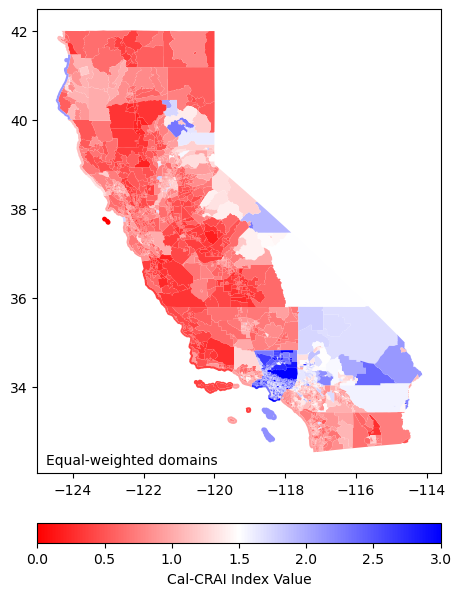

In [16]:
index_plot(calcrai_index_equal_weight, column='calcrai_score', vmin=0, vmax=3)

Number of invalid geometries: 0


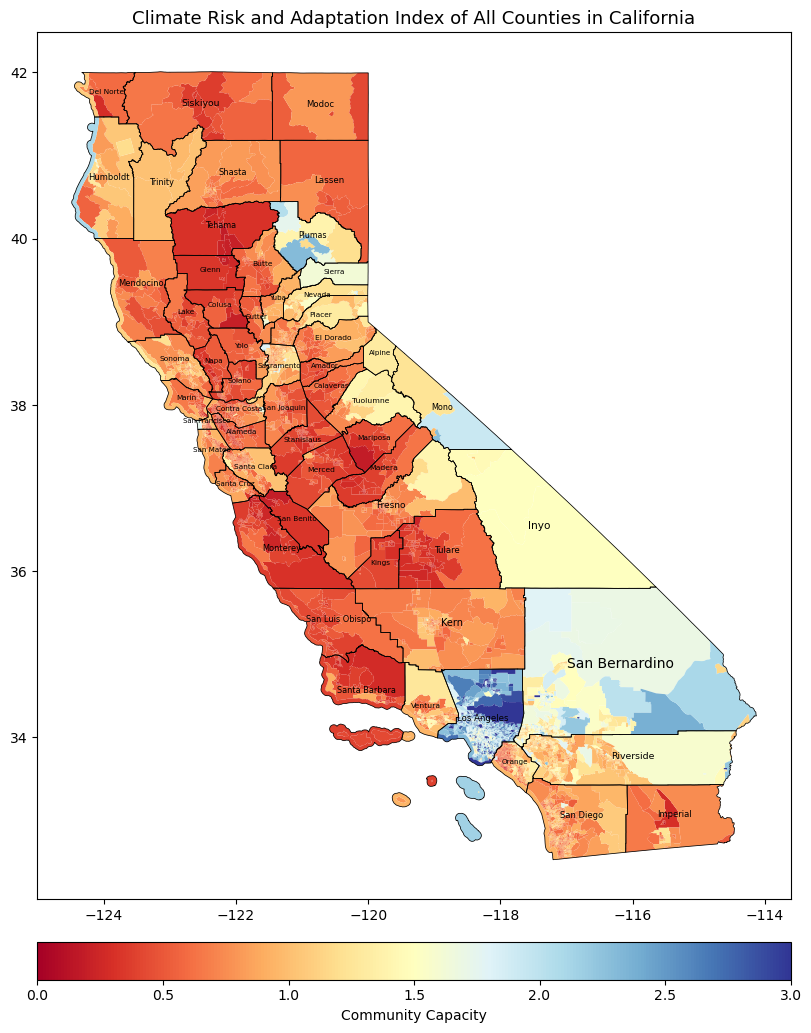

In [17]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None,
                   plot_all=True, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')

Number of invalid geometries: 0


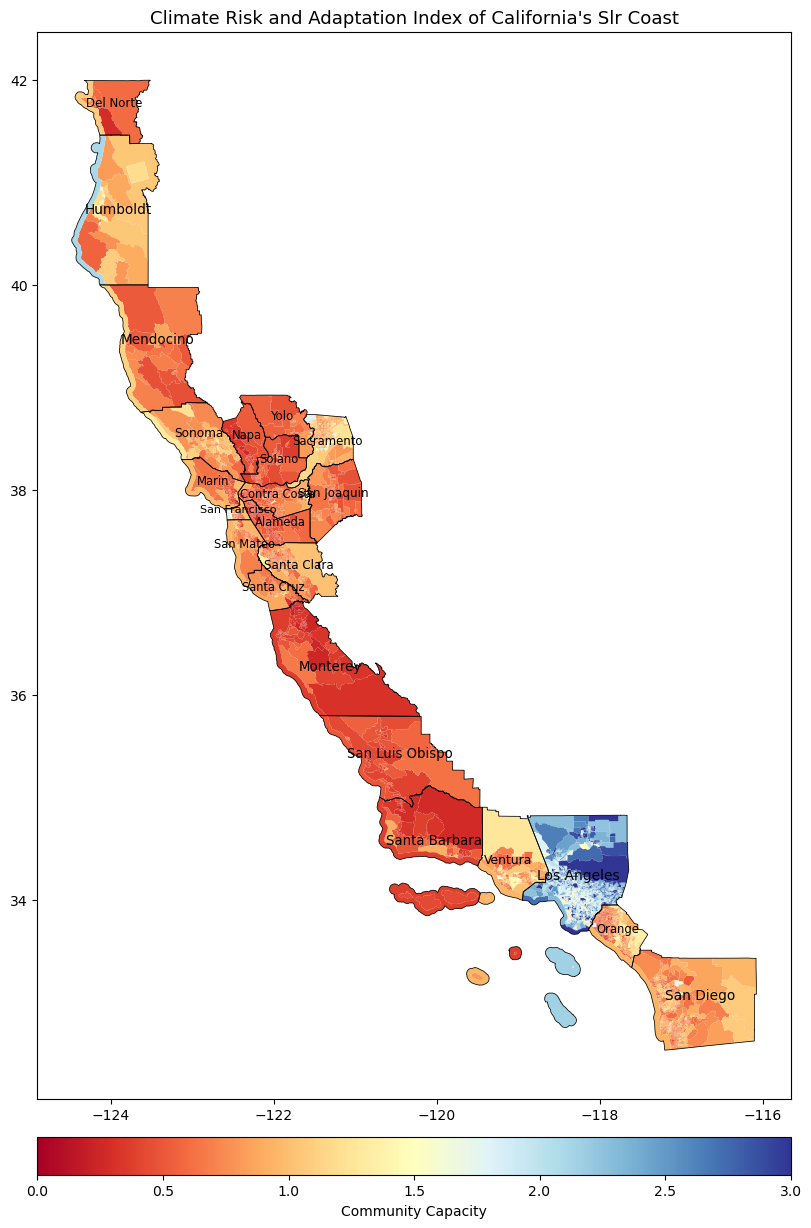

In [18]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None, region='slr_coast',
                   plot_all=False, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')

## 4) Bin the equal-weighted index score into 5 quartiles & visualize

In [19]:
# Binning into quartiles
binned_equal_df = calcrai_index_equal_weight.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.56236002 0.77741668 1.06582079 1.86443031 4.62981188]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,0
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,2
9125,06115041001,1
9126,06115041002,2
9127,06115041101,2


In [20]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,0-20%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


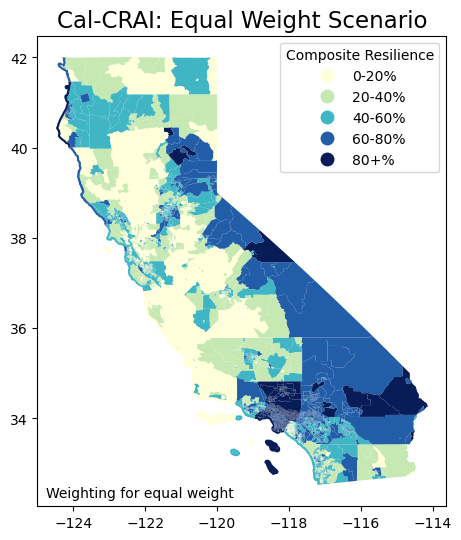

In [21]:
# List of binned columns
binned_columns = [
    'calcrai_score_quartile'
]

# Loop through each binned column and plot
for column in binned_columns:
    scenario_name = 'equal weight'

    index_plot(binned_df_viz, column, save_name=f'binned {scenario_name}', scenario=scenario_name, plot_title=True, vmin=0, vmax=5, plot_type='discrete')

# Step 5) Export as a GeoDataBase

### Merge with census tract and geometry boundaries before exporting to geodatabase

In [22]:
equal_weight_merged = add_census_tracts(calcrai_index_equal_weight)

In [23]:
equal_weight_merged.columns

Index(['GEOID', 'governance_domain_score', 'built_environment_domain_score',
       'natural_systems_domain_score', 'society_economy_domain_score',
       'built_environment_median', 'natural_systems_median',
       'society_economy_median', 'natural_systems_tract_adjusted',
       'society_economy_tract_adjusted', 'built_environment_tract_adjusted',
       'hazard_score', 'community_capacity', 'calcrai_score', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Isolate desired columns for the GeoDataBase file

In [24]:
geodatabase_columns = [
    'GEOID', 
    'governance_domain_score', 'built_environment_domain_score', 'natural_systems_domain_score', 'society_economy_domain_score',
    'built_environment_tract_adjusted', 'natural_systems_tract_adjusted', 'society_economy_tract_adjusted', 
    'community_capacity',  'hazard_score', 'calcrai_score', 
    'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'
]

equal_weight_merged_cleaned = equal_weight_merged[geodatabase_columns]

In [25]:
# Create geometry column
geometry = [Point(xy) for xy in zip(equal_weight_merged['INTPTLON'], equal_weight_merged['INTPTLAT'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(equal_weight_merged, geometry=geometry, crs="EPSG:4269")  # Specify CRS

# Define the output path
gdb_path = r'../index_method/Cal_CRAI.gdb'

# Save to geodatabase
gdf.to_file(gdb_path, layer="cal_climate_resilience_adaptation_index", driver="OpenFileGDB")

## Add metadata do the GeoDataBase file

In [26]:
driver = ogr.GetDriverByName("OpenFileGDB")
gdb = driver.Open(gdb_path, 1)  # Open in write mode

# Create a new table for metadata in the geodatabase
metadata_table = gdb.CreateLayer("Metadata", geom_type=ogr.wkbNone)

# Define the fields for the metadata table
metadata_table.CreateField(ogr.FieldDefn("Column_Name", ogr.OFTString))
metadata_table.CreateField(ogr.FieldDefn("Data_Type", ogr.OFTString))
metadata_table.CreateField(ogr.FieldDefn("Description", ogr.OFTString))

# Add metadata records for each column you want to document
fields = [
    ("GEOID", "object", "Geographical identifier for the census tract. GEOID numbers are generated with the following: STATEFP + COUNTYFP + TRACTCE"),
    ("governance_domain_score", "float64", "Governance domain score, used in the Cal-CRAI calculation"),
    ("built_domain_score", "float64", "Built Environment domain index score, the value used to calculate the Built Environment adjusted score"),
    ("natural_systems_domain_score", "float64", "Natural Systems domain index score, the value used to calculate the Natural Systems adjusted score"),
    ("society_economy_domain_score", "float64", "Society and Economy domain index score, the value used to calculate the society and economy adjusted score"),
    ("natural_systems_tract_adjusted", "float64", "Adjusted value for Natural Systems per census tract"),
    ("society_economy_tract_adjusted", "float64", "Adjusted value for Society and Economy per census tract"),
    ("built_tract_adjusted", "float64", "Adjusted value for Built Environment by tract"),
    ("community_capacity", "float64", "Numerator score of the Cal-CRAI calculation, with each coefficient being 1"),
    ("hazard_score", "float64", "Climate risk assessment score from all climate scenarios: Extreme Heat, Drought, Inland Flooding, Sea Level Rise, and Wildfires"),
    ("calcrai_score", "float64", "Calculated Cal-CRAI scores per California census tract"),
    ("STATEFP", "object", "State FIPS code"),
    ("COUNTYFP", "object", "County FIPS code"),
    ("TRACTCE", "object", "The unique identifier for a Census tract within a county"),
    ("NAME", "object", "This is a simpler, shorter version of the tract's identifier, often used for display purposes."),
    ("NAMELSAD", "object", "Combines the tract's type with its specific number, creating a more human-readable label."),
    ("MTFCC", "object", "A code assigned to describe the feature's type in the U.S. Census Bureau's geographic database. "),
    ("FUNCSTAT", "object", "Functional status of the geographical unit"),
    ("ALAND", "int64", "Land area (in square meters)"),
    ("AWATER", "int64", "Water area (in square meters)"),
    ("INTPTLAT", "object", "Latitude of the intersection point"),
    ("INTPTLON", "object", "Longitude of the intersection point"),
    ("geometry", "geometry", "Spatial component of feature")
]

# Add records for each field to the metadata table
feature_def = metadata_table.GetLayerDefn()
for field in fields:
    feature = ogr.Feature(feature_def)
    feature.SetField("Column_Name", field[0])
    feature.SetField("Data_Type", field[1])
    feature.SetField("Description", field[2])
    metadata_table.CreateFeature(feature)
    feature = None  # Cleanup

# Create an OrderedDict for metadata
metadata_dict = OrderedDict()

# Add metadata in order
metadata_dict["Title"] = "California Climate Risk and Adaptation Index"
metadata_dict["Abstract"] = (
    "The Cal-CRAI evaluates community capacity — the ability of a community to adapt to and recover from a climate event \n"
    " — and hazard risk, which refers to the degree to which communities are exposed to climate risks and the historical losses \n"
    "resulting from such events. This assessment spans a broad set of socioeconomic, built, and natural environment indicators, \n"
    "creating a composite resilience index score that provides insights into California's vulnerability and resilience to climate \n"
    "change impacts at a high spatial scale. The climate risks used have been previously identified as “highest priority” for California: \n"
    "- Extreme heat \n"
    "- Wildfire \n"
    "- Drought \n"
    "- Inland flooding \n"
    "- Sea level rise"
)
metadata_dict["DOI"] = "https://doi.org/10.5281/zenodo.13840187"
metadata_dict["Owner"] = "California Air and Resources Board"
metadata_dict["Produced By"] = "Eagle Rock Analytics, Inc. for California Air Resources Board"
metadata_dict["Point of Contact"] = "Eagle Rock Analytics, Inc.: info@eaglerockanalytics"
metadata_dict["Spatial Reference System"] = "EPSG:4269 (NAD83 - North American Datum 1983)"

metadata_dict["Dataset Dates"] = "publication date TBD"
metadata_dict["Geographic Extent"] = (
    "California, United States; Bounding Box: West: -124.48, East: -114.13, South: 32.53, North: 42.01"
)
metadata_dict["Version"] = "1.0"
metadata_dict["Metadata Date Stamp"] = "2024-12-06"
metadata_dict["Metadata Language"] = "English"
metadata_dict["Metadata Character Set"] = "UTF-8"
metadata_dict["Dataset Language"] = "English"
metadata_dict["Dataset Character Set"] = "UTF-8"
metadata_dict["Topics"] = (
    "Climate Risk Assessment, Climate Change Adaptation, Environmental Resilience, "
    "Socioeconomic Vulnerability, Regional Planning, California, Wildfire, Drought, "
    "Sea Level Rise, Inland Flooding, Extreme Heat"
)

# Add the metadata to the geodatabase
for key, value in metadata_dict.items():
    gdb.SetMetadataItem(key, value)

# Retrieve and print metadata in the order they were added
print('------')
for key, value in metadata_dict.items():
    print(f"{key}: {value}")
print('------')

# Save and close the GDB
gdb.Destroy()

print("Metadata table created successfully in the geodatabase.")

------
Title: California Climate Risk and Adaptation Index
Abstract: The Cal-CRAI evaluates community capacity — the ability of a community to adapt to and recover from a climate event 
 — and hazard risk, which refers to the degree to which communities are exposed to climate risks and the historical losses 
resulting from such events. This assessment spans a broad set of socioeconomic, built, and natural environment indicators, 
creating a composite resilience index score that provides insights into California's vulnerability and resilience to climate 
change impacts at a high spatial scale. The climate risks used have been previously identified as “highest priority” for California: 
- Extreme heat 
- Wildfire 
- Drought 
- Inland flooding 
- Sea level rise
DOI: https://doi.org/10.5281/zenodo.13840187
Owner: California Air and Resources Board
Produced By: Eagle Rock Analytics, Inc. for California Air Resources Board
Point of Contact: Eagle Rock Analytics, Inc.: info@eaglerockanalytics

c:\Users\jesse\miniconda3\envs\carb\lib\site-packages\osgeo\ogr.py:560: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Zip geodatabase files

In [28]:
# Path to the geodatabase directory
gdb_path = '../index_method/Cal_CRAI.gdb'

# Path for the zipped file
zip_path = 'Cal_CRAI.zip'

# Create a zip archive of the geodatabase
shutil.make_archive('Cal_CRAI', 'zip', gdb_path)

print(f"Geodatabase zipped at {zip_path}")

Geodatabase zipped at Cal_CRAI.zip


### Upload to AWS

In [29]:
# AWS bucket and directory
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

# File to upload (the zipped file)
file = 'Cal_CRAI.zip'

# Use the existing function to upload
upload_csv_aws([file], bucket_name, directory)

Cal_CRAI.zip uploaded to AWS
